# 1. Import Libraries

In [ ]:
import os
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras import regularizers

import keras.backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping

from IPython.display import Image, HTML
from tensorflow.keras.utils import plot_model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Dataset/FER2013.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
train_dir='/tmp/train'
test_dir='/tmp/test'

In [ ]:
!unzip gdrive/My\ Drive/Dataset/FER2013

# 2. Parameter

In [ ]:


# Image size

IMAGE_SIZE   = (48,48)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

BS = 64
EPOCHS = 125
ADAM_LEARNING_RATE = 0.0001
PATIENCE =10

classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

# 3. Prepare data

In [ ]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Load datasat

train_dataset  = train_datagen.flow_from_directory(directory = train_dir,
                                                   target_size = IMAGE_SIZE,
                                                   class_mode = 'categorical',
                                                   batch_size = BS)

test_dataset = test_datagen.flow_from_directory(directory = test_dir,
                                                  target_size = IMAGE_SIZE,
                                                  class_mode = 'categorical',
                                                  shuffle =True,
                                                  batch_size = BS)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# 4. Explore data

In [ ]:
# Total train/test sample

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path +"/"+ expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')

HTML(train_count.append(test_count).to_html(escape=False))

,happy,neutral,angry,disgust,surprise,sad,fear
train,7215,4965,3995,436,3171,4830,4097
test,1774,1233,958,111,831,1247,1024


In [ ]:
# Data labels

class_labels = test_dataset.class_indices
class_labels

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
# See the shape of any data

train_sample=next(train_dataset)
print(train_sample[0].shape)

(64, 48, 48, 3)


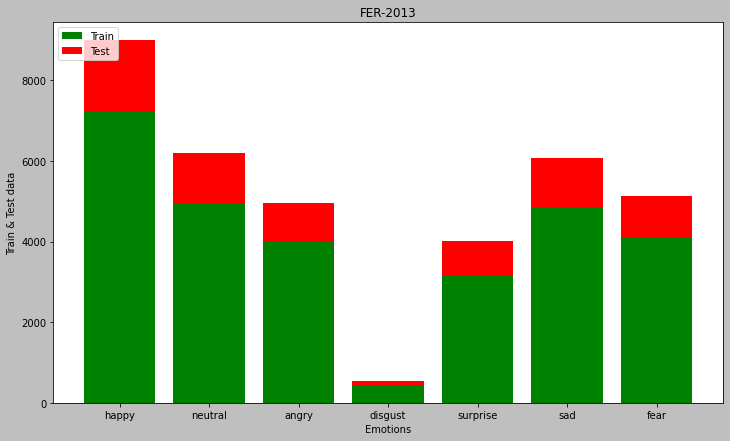

In [ ]:
# # lot distribution of train/test dataste per class

x = list(test_count.columns)
y1 =train_count.iloc[0].to_list()
y2 = test_count.iloc[0].to_list()
plt.figure(figsize=(12,7))

plt.bar(x, y1, color='green')
plt.bar(x, y2, bottom=y1, color='red')
plt.xlabel("Emotions")
plt.ylabel("Train & Test data")
plt.legend(["Train", "Test"], loc='upper left')
plt.title("FER-2013")
plt.savefig('distribution.png')
plt.show()

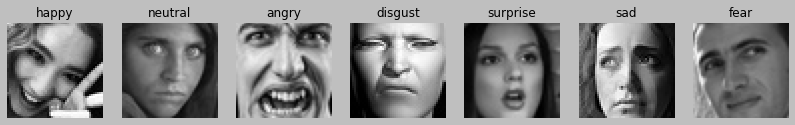

In [ ]:
# Plot image of each class

plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + "/"+expression +'/'+ os.listdir(train_dir + "/"+expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# 5. Model

In [ ]:
# Mobinet

base_model = tf.keras.applications.MobileNet(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
base_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 24, 24, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 24, 24, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 24, 24, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 24, 24, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 24, 24, 32) 

In [ ]:
# Freezing Layers

for layer in base_model.layers[:-9]:
    layer.trainable=False

In [ ]:
print("Model trainable",len(base_model.layers))

Model trainable 86


In [ ]:
print("Model trainable",len(base_model.trainable_variables))

Model trainable 9


In [ ]:
# Model trainable

print("Model trainable",len(base_model.trainable_variables))

Model trainable 9


In [ ]:
# Build transfer learning Model

model=Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001),bias_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(7, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1, 1, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

In [ ]:
# Compile model

def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

adam = tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

ValueError: ignored

In [ ]:
type(train_dataset.classes)

numpy.ndarray

In [ ]:
len(train_dataset.classes)

28709

In [ ]:
# Run Model

counter = Counter(train_dataset.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = PATIENCE,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_dataset,
                  validation_data=test_dataset,
                  epochs = EPOCHS,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)


Epoch 1/125
449/449 [==============================] - 159s 355ms/step - loss: 1.5570 - accuracy: 0.9100 - precision: 0.7682 - recall: 0.5301 - auc: 0.9267 - f1_score: 0.6265 - val_loss: 1.4788 - val_accuracy: 0.8792 - val_precision: 0.6096 - val_recall: 0.4296 - val_auc: 0.8604 - val_f1_score: 0.5011 - lr: 1.2500e-05
Epoch 2/125
449/449 [==============================] - 159s 355ms/step - loss: 1.5623 - accuracy: 0.9101 - precision: 0.7661 - recall: 0.5337 - auc: 0.9272 - f1_score: 0.6284 - val_loss: 1.4833 - val_accuracy: 0.8791 - val_precision: 0.6089 - val_recall: 0.4295 - val_auc: 0.8594 - val_f1_score: 0.5025 - lr: 1.2500e-05
Epoch 3/125
449/449 [==============================] - 160s 355ms/step - loss: 1.5628 - accuracy: 0.9097 - precision: 0.7648 - recall: 0.5308 - auc: 0.9266 - f1_score: 0.6256 - val_loss: 1.4843 - val_accuracy: 0.8794 - val_precision: 0.6106 - val_recall: 0.4298 - val_auc: 0.8595 - val_f1_score: 0.5026 - lr: 1.2500e-05
Epoch 4/125
449/449 [===================

# 6. Evaluate Model

## 6.1 Check some Score 

In [ ]:
#  Som Scores of train & test set

train_evalation = model.evaluate(train_dataset)
test_evaluation = model.evaluate(test_dataset)

RuntimeError: ignored

In [ ]:
metric_list = ["Loss","Accuracy", "Precision", "Recall", "Auc", "F1_Score"]

df = pd.DataFrame(list(zip(metric_list, 
                           [round(num, 3) for num in train_evalation], 
                           [round(num, 3) for num in test_evaluation])),
                  columns=['Metric Name', 'Train', 'Validate'])

print('\n\nModel Scores\n')

HTML(df.to_html(escape=False))


NameError: ignored

## 6.2 Visualize results

In [ ]:
hs=history.history

acc = hs['accuracy']
val_acc = hs['val_accuracy']
loss =  hs['loss']
val_loss = hs['val_loss']
auc =  hs['auc']
val_auc = hs['val_auc']
precision =hs['precision']
val_precision =hs['val_precision']
f1 = hs['f1_score']
val_f1 = hs['val_f1_score']              

plt.style.use('Solarize_Light2')

fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['training', 'validation'])


ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title('History of Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend(['training', 'validation'])

ax3.plot(range(1, len(auc) + 1), auc)
ax3.plot(range(1, len(val_auc) + 1), val_auc)
ax3.set_title('History of AUC')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('AUC')
ax3.legend(['training', 'validation'])

ax4.plot(range(1, len(precision) + 1), precision)
ax4.plot(range(1, len(val_precision) + 1), val_precision)
ax4.set_title('History of Precision')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Precision')
ax4.legend(['training', 'validation'])

ax5.plot(range(1, len(f1) + 1), f1)
ax5.plot(range(1, len(val_f1) + 1), val_f1)
ax5.set_title('History of F1-score')
ax5.set_xlabel('Epochs')
ax5.set_ylabel('F1 score')
ax5.legend(['training', 'validation'])

plt.show()

NameError: ignored

## 6.3 Confusion Matrix

In [ ]:
y_true = test_dataset.classes
y_pred =  model.predict(test_dataset)
y_pred= tf.argmax(y_pred, axis = 1).numpy()

cm = confusion_matrix(y_true = y_true, y_pred = y_pred)

113/113 [==============================] - 15s 125ms/step


Confusion matrix, without normalization

[[ 951    0    6    1    0    0    0]
 [ 109    0    0    1    1    0    0]
 [1011    1    6    5    0    1    0]
 [1749    0   12   10    3    0    0]
 [1219    0    9    3    2    0    0]
 [1229    0   11    5    2    0    0]
 [ 825    1    2    3    0    0    0]]





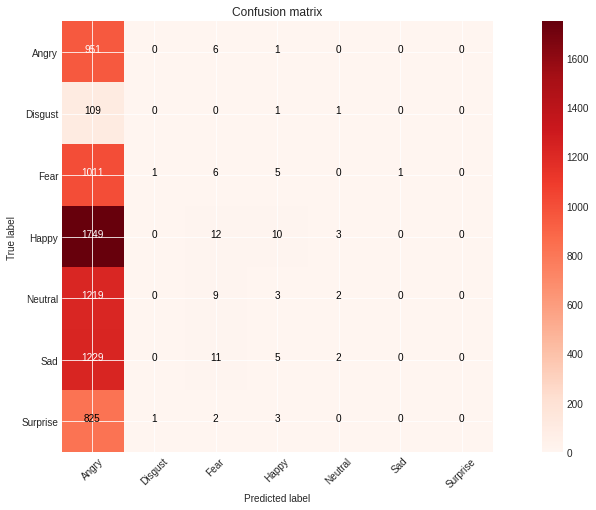

In [ ]:
plt.rcParams['figure.figsize'] = (14,7)

plt.style.use('seaborn-darkgrid')
plt.imshow(cm, interpolation='nearest', cmap='Reds')
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)    

print('Confusion matrix, without normalization\n')   
print(cm)

print("\n\n")
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

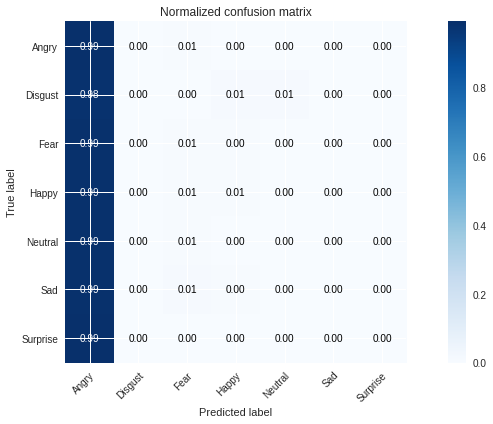

In [ ]:
plt.style.use('seaborn')

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(12,6))

im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title = 'Normalized confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


fmt = '.2f' 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
model = load_model("/content/gdrive/MyDrive/model/mobilenet.h5", custom_objects={'f1_score': f1_score})

predictions = model.predict(test_dataset)

# Display a graph of the predictions
plt.bar(test_dataset.class_indices.keys(), predictions.mean(axis=0))
plt.xlabel('Classes')
plt.ylabel('Prediction')
plt.show()

NameError: ignored

# 7. Save Model

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

NameError: ignored

In [ ]:
model.save("mobilenet.h5")

In [ ]:
from google.colab import files

files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

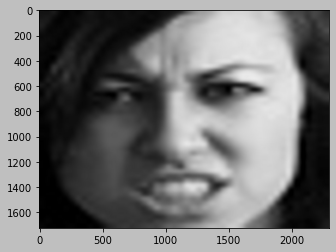

In [ ]:
import cv2
import matplotlib.pyplot as plt
plt.style.use('grayscale')
plt.grid(visible=None)
img_path1='/Training_4530522.jpg'

# Read image
img1 = cv2.imread(img_path1)



# Display the image
plt.imshow(img1)
plt.show()


# 8. Test/Predict

In [ ]:
img=image.load_img(img_path1,target_size=IMAGE_SIZE)
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 48, 48, 3)


In [ ]:
result=model.predict(img)
print(result)
y_pred=np.argmax(result[0])
print(y_pred)
print('The person facial emotion is:',classes[y_pred])

NameError: ignored

In [ ]:
final_layer = model.layers[-1]

In [ ]:
weights = final_layer.get_weights()
print(weights)

[array([[-0.17029232,  0.09911646, -0.18165474, -0.13018528,  0.00889701,
         0.14468063,  0.18941359],
       [ 0.03829421,  0.09700753, -0.04292284,  0.00982004, -0.16413304,
         0.18810283, -0.08580104],
       [-0.09807985, -0.00156309, -0.09207693,  0.15233962, -0.14746511,
        -0.18286744,  0.06863947],
       [-0.15526739, -0.02732792,  0.14724515, -0.17661607, -0.17890137,
         0.06519435,  0.06439944],
       [ 0.11393504,  0.08794038, -0.20615019, -0.0488508 , -0.16882187,
        -0.11533646,  0.1932293 ],
       [-0.19170484, -0.05314589,  0.09992836,  0.10483278, -0.15391733,
        -0.00492543, -0.00158389],
       [ 0.00147165,  0.09854691, -0.06922032,  0.07293867,  0.17448507,
        -0.01971452,  0.00963724],
       [ 0.20523109,  0.0114823 ,  0.1943856 ,  0.04769854, -0.20799464,
        -0.07685201, -0.0235294 ],
       [ 0.01518954, -0.03657024,  0.08324571,  0.08885272, -0.14977615,
        -0.0821811 ,  0.01572911],
       [ 0.05127938,  0.139

In [ ]:
weights = model.layers[-1].get_weights()[0]
print(weights)

[[-0.17029232  0.09911646 -0.18165474 -0.13018528  0.00889701  0.14468063
   0.18941359]
 [ 0.03829421  0.09700753 -0.04292284  0.00982004 -0.16413304  0.18810283
  -0.08580104]
 [-0.09807985 -0.00156309 -0.09207693  0.15233962 -0.14746511 -0.18286744
   0.06863947]
 [-0.15526739 -0.02732792  0.14724515 -0.17661607 -0.17890137  0.06519435
   0.06439944]
 [ 0.11393504  0.08794038 -0.20615019 -0.0488508  -0.16882187 -0.11533646
   0.1932293 ]
 [-0.19170484 -0.05314589  0.09992836  0.10483278 -0.15391733 -0.00492543
  -0.00158389]
 [ 0.00147165  0.09854691 -0.06922032  0.07293867  0.17448507 -0.01971452
   0.00963724]
 [ 0.20523109  0.0114823   0.1943856   0.04769854 -0.20799464 -0.07685201
  -0.0235294 ]
 [ 0.01518954 -0.03657024  0.08324571  0.08885272 -0.14977615 -0.0821811
   0.01572911]
 [ 0.05127938  0.13946997 -0.20368664 -0.08133632  0.12396081  0.00704874
  -0.09553905]
 [ 0.15616922 -0.17560568  0.02627505  0.17346503 -0.14368533  0.16414694
  -0.04300024]
 [-0.14812768  0.00175